# LABORATORIO 1
## Exploración, preparación y regresión lineal 
En este laboratorio se realiza el análisis y preparación de un conjunto de datos clínicos para construir un modelo de regresión lineal que permita estimar el **CVD Risk Score** a partir de diferentes factores de riesgo.

#### Autores:
* Sergio Ferreira
* Juan David Gutierrez Rodriguez

---
## 1. Importación de las librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant

---
## 2 .Carga de los datos

In [2]:
data_cvd = pd.read_csv('data/Datos Lab 1.csv')

# Trabajamos con una copia de los datos
data = data_cvd.copy()

data.sample(3)

,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
537,VxVS4747,"December 05, 2025",M,50.0,62.459,1.579,20.474,NaN,177/81,181.0,...,High,Y,NaN,0.648,177.0,81.0,Hypertension Stage 1,115.0,16.565,HIGH
21,HDXx4497,2020-09-13,F,NaN,118.500,1.770,37.800,91.7,121/84,185.0,...,Low,N,177.0,0.518,121.0,84.0,Hypertension Stage 1,125.0,19.310,HIGH
721,jaLK7743,29 Feb 20,M,34.0,94.400,1.620,36.000,91.0,100/63,207.0,...,High,Y,162.0,0.562,100.0,63.0,Normal,114.0,16.340,INTERMEDIARY


---
## 3. Limpieza inicial de los datos

### Pacientes duplicados
Inicialmente vamos a verificar si existen pacientes duplicados y de existir guardar únicamente la entrada más reciente.

In [3]:
dup_counts = (data['Patient ID'].value_counts()
                        .loc[lambda s: s > 1]
                        .sort_values(ascending=False))

dup_counts if len(dup_counts) else print("No hay pacientes duplicados.")

Patient ID
oSqq7069    3
gBFe4249    3
AhYt1346    3
RlsB8509    3
RwGu5647    3
           ..
rKiV2789    2
ejaQ6145    2
ahGL8318    2
MgXe4245    2
pgnn4679    2
Name: count, Length: 171, dtype: int64

Para poder comparar las fechas de servicio en la columna *Date of Service* vamos a estandarizar las fechas, pues están con formatos mezclados, para esto utilizaremos la función `to_datetime` de la librería `pandas`.

In [4]:
data['Date of Service'] = pd.to_datetime(data['Date of Service'], format='mixed')
data.sample(3)

,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
849,Mzzo2022,2021-10-03,M,35.0,83.600,1.700,28.900,101.800,141/81,118.0,...,High,Y,170.000,0.599,141.0,81.0,Hypertension Stage 1,30.0,15.190,INTERMEDIARY
1464,FOIA8957,2021-08-02,M,37.0,NaN,1.710,31.300,104.200,130/89,193.0,...,High,Y,171.000,0.609,130.0,89.0,Hypertension Stage 1,100.0,18.620,INTERMEDIARY
1140,fHdM9248,2020-07-05,F,54.0,98.343,1.887,35.973,103.284,104/99,295.0,...,Moderate,N,188.711,0.547,104.0,99.0,Hypertension Stage 2,201.0,20.295,LOW


Cómo se observa ahora todas las fechas mantienen el formato `YYYY-MM-DD`, así que podemos eliminar los registros duplicados de un paciente.

In [5]:
data = data.sort_values(['Patient ID', 'Date of Service'], ascending=[True, False])
data = data.drop_duplicates(subset='Patient ID', keep='first')

### Valores atípicos
Para el buen comportamiento del modelo de regresión es importante eliminar valores atípicos pues el error cuadrático medio usado para optimizar el modelo puede ser sensible a dichos valores. Para observar los valores atípicos seguiremos el criterio de estar 1.5 veces el tamaño del rango intercuartílico alejado de un cuartil extremo.

In [6]:
columns = data.select_dtypes(include=['number']).columns
resultados = []

for columna in columns:
    datos = data[columna].dropna()

    q1 = datos.quantile(0.25)
    q3 = datos.quantile(0.75)
    iqr = q3 - q1

    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr

    n_outliers = ((datos < limite_inferior) | (datos > limite_superior)).sum()

    resultados.append({
        'variable': columna,
        'outliers': n_outliers
    })

outliers_df = pd.DataFrame(resultados)
outliers_df.sort_values(by='outliers', ascending=False)

,variable,outliers
13,CVD Risk Score,50
11,Diastolic BP,16
9,Waist-to-Height Ratio,13
7,Fasting Blood Sugar (mg/dL),13
0,Age,10
10,Systolic BP,9
3,BMI,7
12,Estimated LDL (mg/dL),7
8,Height (cm),4
2,Height (m),4


Inicialmente, eliminaremos los outliers existentes en *CVD Risk Score* puesto que al ser la variable a predecir, estos valores pueden sesgar altamente el modelo.

In [7]:
q1 = data['CVD Risk Score'].quantile(0.25)
q3 = data['CVD Risk Score'].quantile(0.75)
iqr = q3 - q1

limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

data = data[(data['CVD Risk Score'] > limite_inferior) & (data['CVD Risk Score'] < limite_superior)]

Para las demás columnas observaremos diagramas de puntos para observar la dispersión y valores atípicos.

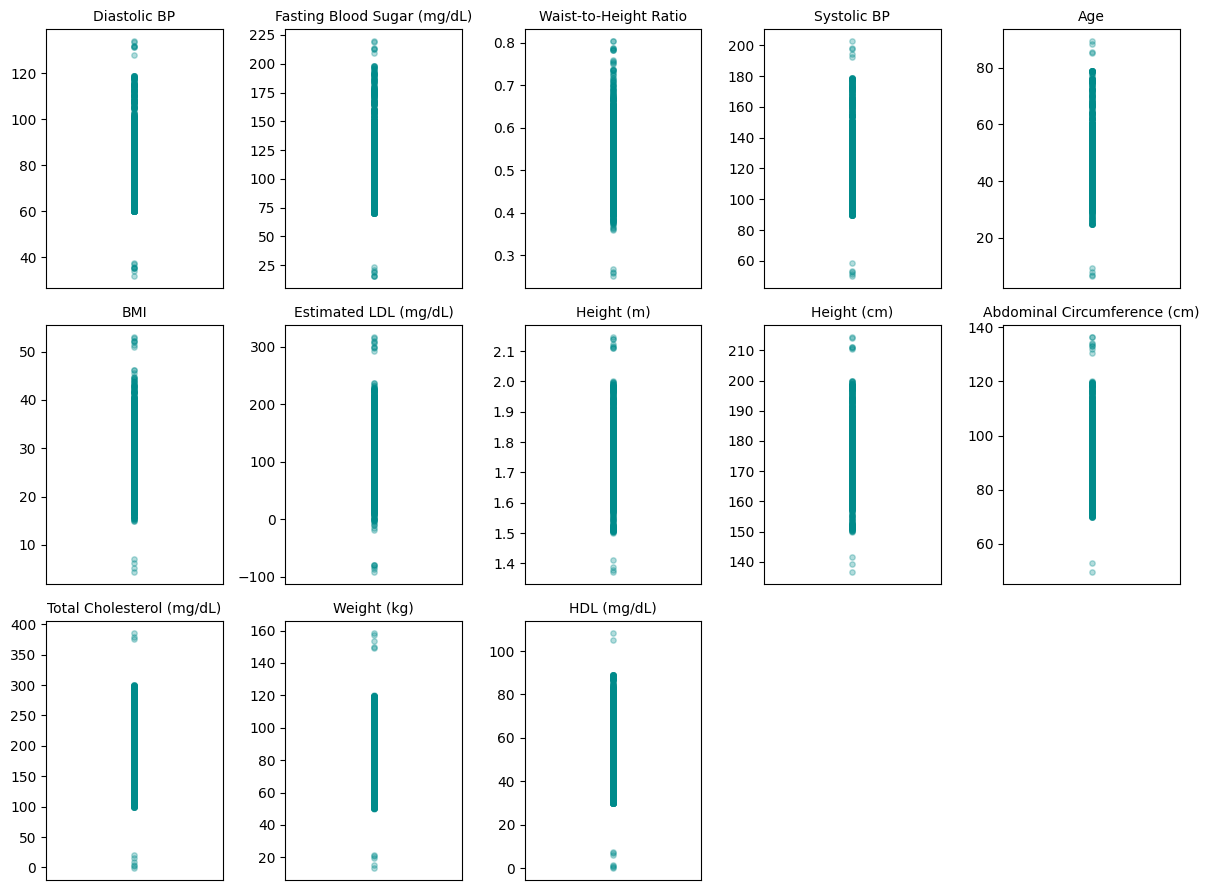

In [8]:
columnas = ['Diastolic BP', 'Fasting Blood Sugar (mg/dL)', 'Waist-to-Height Ratio', 'Systolic BP', 'Age', 'BMI', 'Estimated LDL (mg/dL)',
            'Height (m)', 'Height (cm)', 'Abdominal Circumference (cm)', 'Total Cholesterol (mg/dL)', 'Weight (kg)', 'HDL (mg/dL)']
fig, axes = plt.subplots(3, 5, figsize=(12, 9))
axes = axes.flatten()

for i, columna in enumerate(columnas):
    datos = data[columna].dropna()

    x = np.zeros_like(datos)
    
    axes[i].scatter(x, datos, alpha=0.3, s=15, color='darkcyan')
    
    axes[i].set_title(columna, fontsize=10)
    axes[i].set_xticks([])
    axes[i].set_xlim(-0.2, 0.2)
for j in range(len(columnas), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Según los resultados de las gráficas se observan grupos de valores atípicos lejanos de la distribución de los datos, estos valores inviables tienen efectos negativos en un modelo de regresión. Por ejemplo podemos ver que los pesos menores a 30 kg son imposibles para personas adultas de más de 170 cm de estatura, pesos de más de 140kg imposibles para BMI menores a 40, alturas en centimetros que no corresponden a la medición en metros o edades menores a 10 años imposibles para personas de más de 60 kg de peso.

In [9]:
data[data['Weight (kg)'] < 30]

,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
1317,ELJn5714,2025-08-04,M,38.0,21.038,1.820,22.600,NaN,113/94,165.0,...,Moderate,Y,182.000,0.541,113.0,94.0,Hypertension Stage 2,79.0,13.470,INTERMEDIARY
291,UQyn8657,2024-08-30,F,37.0,15.036,1.870,25.900,87.600,113/75,252.0,...,High,Y,187.000,0.468,113.0,75.0,Normal,143.0,17.870,HIGH
1041,gdBF9655,2025-03-28,F,68.0,19.578,1.995,29.507,103.497,128/88,134.0,...,Low,N,199.548,0.519,128.0,88.0,Hypertension Stage 1,59.0,14.981,HIGH
1579,raYH9048,2020-07-30,M,40.0,21.316,1.900,24.300,NaN,90/72,216.0,...,High,N,190.000,0.380,90.0,72.0,Normal,125.0,13.680,LOW
1233,uOzX6728,2025-03-24,F,56.0,13.261,1.730,33.400,93.800,145/79,208.0,...,Moderate,N,173.000,0.542,145.0,79.0,Hypertension Stage 2,117.0,18.090,INTERMEDIARY


In [10]:
data[data['Weight (kg)'] > 140]


,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
1257,HfIi7486,2022-03-30,F,41.0,158.523,1.700,22.500,75.200,139/60,190.0,...,Low,Y,170.000,0.442,139.0,60.0,Hypertension Stage 1,127.0,17.250,HIGH
223,IaFm9277,2024-10-17,F,60.0,153.556,1.620,NaN,87.200,141/70,174.0,...,Low,N,162.000,0.538,141.0,70.0,Hypertension Stage 2,73.0,17.890,HIGH
1366,KgNL3824,2025-01-12,F,32.0,157.164,1.898,36.837,72.410,125/111,233.0,...,High,Y,189.815,0.381,125.0,NaN,Hypertension Stage 2,151.0,18.277,INTERMEDIARY
586,KjcW1284,2025-11-24,F,35.0,149.335,1.780,NaN,119.672,113/65,173.0,...,High,Y,177.996,0.672,113.0,65.0,Normal,83.0,18.323,HIGH
646,sIAo1776,2025-07-08,F,45.0,149.877,1.616,39.633,109.352,175/98,256.0,...,High,Y,161.584,0.677,175.0,98.0,Hypertension Stage 2,151.0,23.797,LOW


In [11]:
data[data['Age'] < 10]


,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
45,DhUJ7239,2020-01-24,M,6.420,69.769,1.696,22.060,74.184,120/76,197.0,...,Low,N,169.560,0.438,120.0,76.0,Elevated,NaN,14.352,INTERMEDIARY
331,WdVf6550,2021-05-11,M,9.376,87.055,1.527,23.245,96.493,103/72,132.0,...,Low,N,152.679,0.632,103.0,72.0,Normal,22.0,12.439,INTERMEDIARY
1553,qXdE2915,2021-08-25,M,7.025,98.700,1.630,37.100,89.700,139/93,158.0,...,Moderate,Y,163.000,0.550,139.0,93.0,Hypertension Stage 1,64.0,19.530,HIGH
1172,rVeE6392,2022-08-06,F,8.038,112.520,1.520,21.988,106.120,117/96,228.0,...,Low,Y,152.020,0.698,117.0,96.0,Hypertension Stage 2,158.0,16.808,LOW


In [12]:
data[data['Height (cm)'] > 200]

,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
130,BQvQ6431,2020-09-11,M,33.0,118.300,1.690,41.400,72.10,116/93,171.0,...,Moderate,N,210.554,0.427,116.0,93.0,Hypertension Stage 2,97.0,17.500,LOW
1604,CCbF3794,2024-12-13,F,58.0,69.000,1.870,19.700,77.50,107/88,184.0,...,Low,Y,210.981,0.414,107.0,88.0,Hypertension Stage 1,109.0,14.970,HIGH
1084,GDej6322,2022-09-26,M,55.0,88.834,1.665,27.856,91.37,120/75,106.0,...,Low,N,210.624,NaN,120.0,75.0,Elevated,39.0,13.691,INTERMEDIARY
608,faat5690,2022-12-14,F,46.0,88.100,1.630,33.200,98.70,95/81,166.0,...,Low,Y,213.920,0.606,95.0,81.0,Hypertension Stage 1,58.0,16.710,HIGH
433,lBNs4776,2024-12-26,F,57.0,100.800,1.840,29.800,88.40,110/78,102.0,...,High,N,214.394,0.480,110.0,78.0,Normal,39.0,15.500,HIGH
1277,qcdy4813,2023-11-12,M,37.0,78.100,1.850,22.800,74.20,100/76,118.0,...,Moderate,N,211.127,0.401,100.0,76.0,Normal,18.0,13.920,LOW


In [13]:
rangos = {
    'Diastolic BP': (40, 125),
    'Systolic BP': (80, 190),
    'Fasting Blood Sugar (mg/dL)': (60, 200),
    'Total Cholesterol (mg/dL)': (80, 320),
    'HDL (mg/dL)': (20, 100),
    'Estimated LDL (mg/dL)': (0, 250),
    'BMI': (15, 50),
    'Weight (kg)': (30, 140),
    'Height (m)': (1.45, 2),
    'Height (cm)': (145, 200),
    'Abdominal Circumference (cm)': (60, 130),
    'Waist-to-Height Ratio': (0.35, 0.8),
    'Age': (18, 100)
}

In [14]:
for col, (min_val, max_val) in rangos.items():
    if col in data.columns:
        data.loc[
            (data[col] <= min_val) | (data[col] >= max_val),
            col
        ] = np.nan
        
data.describe()

,Date of Service,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Estimated LDL (mg/dL),CVD Risk Score
count,1298,1236.000000,1227.000000,1241.000000,1243.000000,1243.000000,1234.000000,1224.000000,1240.000000,1233.000000,1230.000000,1235.000000,1228.000000,1227.000000,1298.000000
mean,2022-12-03 22:21:15.808936,47.262816,86.198337,1.755085,28.557304,91.758523,198.984603,56.253268,117.066935,175.518969,0.525837,125.824291,82.981270,112.840261,16.967587
min,2020-01-02 00:00:00,25.000000,50.100000,1.502000,15.100000,70.000000,100.000000,30.000000,70.000000,150.000000,0.360000,90.000000,60.000000,1.000000,10.530000
25%,2021-05-27 12:00:00,37.000000,67.350000,1.668000,22.680500,80.544500,151.000000,42.000000,92.000000,166.984000,0.458250,108.000000,71.000000,63.000000,15.170000
50%,2022-11-05 00:00:00,47.000000,87.400000,1.760000,28.300000,91.500000,197.000000,56.000000,115.000000,176.000000,0.522000,125.000000,82.000000,111.000000,16.899000
75%,2024-07-06 00:00:00,56.000000,105.050000,1.846000,34.152000,102.286000,250.000000,70.000000,138.000000,184.449000,0.583750,141.000000,94.000000,159.000000,18.671250
max,2025-12-30 00:00:00,89.420000,120.000000,1.998000,46.200000,119.996000,300.000000,89.000000,198.000000,199.960000,0.787000,179.000000,119.000000,237.000000,24.170000
std,NaN,12.650537,20.980157,0.113150,7.056570,12.839031,57.519408,16.136009,30.459084,11.309207,0.083041,22.105700,14.819714,57.653778,2.499918


---
## 4. Partición de los datos

Separamos los datos en dos conjuntos: entrenamiento (**train**) y prueba (**test**). Se define también que la variable dependiente es el `CVD Risk Score`, y el resto de las variables se consideran como variables predictoras.

In [15]:
target = "CVD Risk Score"

X = data.drop(columns=[target])
y = data[target]

Utilizaremos el **75 %** de los datos para entrenar el modelo y el **25 %** restante para evaluarlo.

In [16]:
X_train, X_test, y_train, y_test = train_test_split( 
    X, 
    y, 
    test_size=0.25, 
    random_state=42
)

---
## 5. Construcción del pipeline

Creamos una función que elimina las columnas que no deseamos incluir en la predicción, aquellas que consideramos que no aportan información significativa para estimar el *CVD Risk Score*.

In [17]:
cols_to_drop = ['Patient ID', 'Date of Service', 'Blood Pressure (mmHg)', 'CVD Risk Level']

def drop_columns(df):
    return df.drop(
        columns=cols_to_drop,
        errors="ignore"
    )

dropper = FunctionTransformer(drop_columns)

Identificamos las variables númericas y categoricas.

In [18]:
numeric_features = [
    "Age", "Weight (kg)", "Height (m)", "BMI", "Abdominal Circumference (cm)", 
    "Total Cholesterol (mg/dL)", "HDL (mg/dL)", "Fasting Blood Sugar (mg/dL)", 
    "Waist-to-Height Ratio", "Systolic BP", "Diastolic BP", "Estimated LDL (mg/dL)"
]

ordinal_features = [
    "Physical Activity Level", "Blood Pressure Category"
]

binary_features = [
    "Sex", "Smoking Status", "Diabetes Status", "Family History of CVD"
]

#### Transformación de variables númericas
* **Completitud:** Los valores faltantes se imputarán utilizando la media de cada variable.
* **Escalamiento:** Se utilizará la herramienta `StandardScaler()` para llevar los valores a una escala comparable.

In [19]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

#### Transformación de variables categoricas
* **Binarias:** Codificaremos los valores (`N`, `Y`) y (`M`, `F`) como (`0`, `1`).
* **Ordinales:** Usaremos un valor númerico para codificar cada categoria respetando su jerarquía.

In [20]:
binary_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="if_binary", handle_unknown="ignore"))
])

ordinal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(categories=[
        ['Low', 'Moderate', 'High'],
        ['Normal', 'Elevated', 'Hypertension Stage 1', 'Hypertension Stage 2']
    ]))
])

Asignamos cada transformador a las columnas correspondientes.

In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("bin", binary_transformer, binary_features),
        ("ord", ordinal_transformer, ordinal_features)
    ]
)

Se definen transformaciones sobre los atributos `Total Cholesterol` y `Estimated LDL` para asegurar el atributo de validez.

In [22]:
def cleaning_conditions(df):
    df = df.copy()

    # Total Cholesterol
    df["Total Cholesterol (mg/dL)"] = df["Total Cholesterol (mg/dL)"].abs()

    # Estimated LDL
    df["Estimated LDL (mg/dL)"] = df["Estimated LDL (mg/dL)"].abs()

    return df

clean_conditions = FunctionTransformer(cleaning_conditions)

Ahora definimos `pipeline_regresion` como un pipeline completo de extremo a extremo, que encadena todas las transformaciones sobre los datos junto con el modelo de regresión lineal. Se tienen todos los pasos que definimos anteriormente, secuenciadas en el orden que queremos que se ejecute:

In [23]:
pipeline_regresion = Pipeline(steps=[
    ("dropper", dropper),
    ("clean_conditions", clean_conditions),
    ("preprocesamiento", preprocessor),
])

set_config(display="diagram")

pipeline_regresion

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('dropper', ...), ('clean_conditions', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function dro...002C7304A02C0>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword argumen

Usamos otra variable para no afectar el conjunto de entrenamiento original. Adicionalmente, transformamos nuestros datos en un nuevo dataframe para incluir la codificación de las variables categóricas.

In [24]:
Xt_train = pipeline_regresion.fit_transform(X_train)

feature_names = pipeline_regresion.named_steps["preprocesamiento"].get_feature_names_out()

Xt_train_df = pd.DataFrame(
    Xt_train.toarray() if hasattr(Xt_train, "toarray") else Xt_train,
    columns=feature_names,
    index=X_train.index
)

---
## 6. Multicolinealidad

In [25]:
# TODO: Hacer correcciones si es necesario para evitar multicolinealidad antes de entrenar el modelo.

<Axes: >

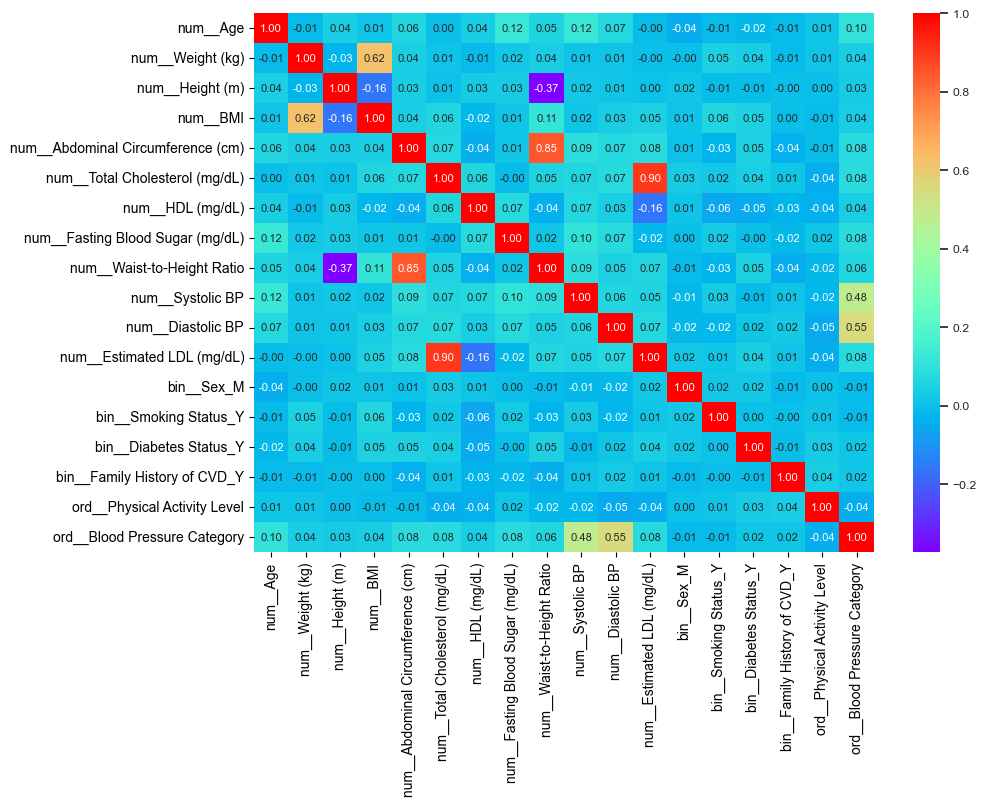

In [26]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.set_theme(font_scale=0.8)
sns.heatmap(Xt_train_df.corr(), ax=ax, cmap='rainbow', annot=True, fmt='.2f', annot_kws={"size": 8})

In [27]:
X_vif = Xt_train_df.select_dtypes(include="number").copy()

clean_columns = (
    X_vif.columns
         .str.replace("^num__", "", regex=True)
         .str.replace("^cat__", "", regex=True)
)

vif_values = []

with np.errstate(divide="ignore", invalid="ignore"):
    for i in range(X_vif.shape[1]):
        vif = variance_inflation_factor(X_vif.values, i)
        vif_values.append(vif)

vif_data = pd.DataFrame({
    "Variable": clean_columns,
    "VIF": vif_values
})

print(vif_data)

                        Variable       VIF
0                            Age  1.040697
1                    Weight (kg)  1.661650
2                     Height (m)  2.400889
3                            BMI  1.714990
4   Abdominal Circumference (cm)  7.235463
5      Total Cholesterol (mg/dL)  6.917529
6                    HDL (mg/dL)  1.373738
7    Fasting Blood Sugar (mg/dL)  1.036122
8          Waist-to-Height Ratio  8.419896
9                    Systolic BP  1.253793
10                  Diastolic BP  1.326747
11         Estimated LDL (mg/dL)  7.074578
12                    bin__Sex_M  1.856669
13         bin__Smoking Status_Y  1.889452
14        bin__Diabetes Status_Y  1.897421
15  bin__Family History of CVD_Y  1.851566
16  ord__Physical Activity Level  2.314496
17  ord__Blood Pressure Category  4.201702


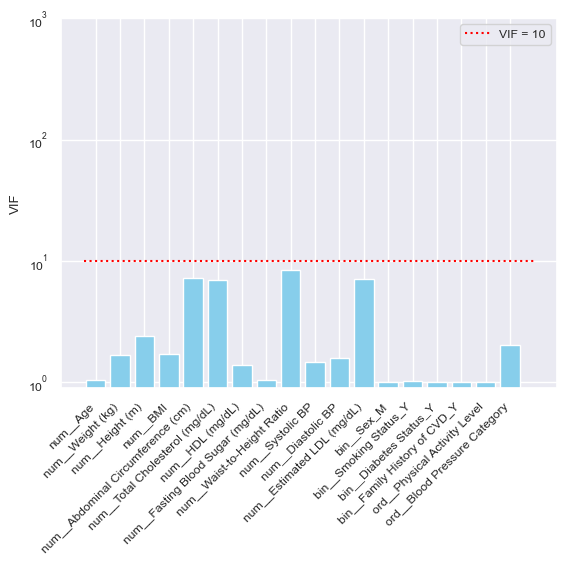

In [30]:
# VIF score
def plot_vif(data, y_max = 12, scale = None):
    X = add_constant(data)
    vif = pd.DataFrame()
    vif['Variable'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif.iloc[1:]
    plt.bar(vif['Variable'], vif['VIF'], color='skyblue')
    plt.hlines(10, -0.5, len(vif), colors='red', linestyles='dotted', label='VIF = 10')
    if scale == 'log': 
        plt.yscale('log', base = 10)
        plt.ylim(0.9, y_max)
    else:
        plt.ylim(0, y_max)
    plt.ylabel('VIF')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.show()
    
plot_vif(Xt_train_df, y_max=1000, scale='log')

---
## 7. Modelo de regresión lineal 1

### Entrenamiento
Primero, Usamos la función `.fit()` para entrenar y aprender los parámetros con base en los datos.

In [ ]:
Modelo = LinearRegression()

Modelo.fit(Xt_train_df,y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


Solicitamos al modelo que genere las predicciones sobre el conjunto de entrenamiento.

In [ ]:
y_train_pred = Modelo.predict(Xt_train_df)

### Validación de entrenamiento
Analizamos qué tan alejadas están las predicciones respecto a los valores reales de la variable objetivo.

In [ ]:
# Mean Absolute Error (MAE)
mae_train = mean_absolute_error(y_train, y_train_pred)
print("MAE  train:", mae_train)


# Root Mean Squeared Error (RMSE)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("RMSE train:", rmse_train)


# Coeficiente de determinación R^2
r2_train = r2_score(y_train, y_train_pred)
print("R² train:", r2_train)

MAE  train: 0.24540767273823333
RMSE train: 0.6365011529494151
R² train: 0.9359223527991101


### Capacidad de generalización
Ahora evaluamos el modelo utilizando el conjunto de prueba (**test**), lo que permite analizar su capacidad de generalización al enfrentarse a datos no vistos durante el entrenamiento.

In [ ]:
Xt_test = pipeline_regresion.transform(X_test)

feature_names = pipeline_regresion.named_steps["preprocesamiento"].get_feature_names_out()

Xt_test_df = pd.DataFrame(
    Xt_test.toarray() if hasattr(Xt_test, "toarray") else Xt_test,
    columns=feature_names,
    index=X_test.index
)

Solicitamos al modelo que genere las predicciones sobre el conjunto de prueba.

In [ ]:
y_test_pred = Modelo.predict(Xt_test_df)

### Validación de generalización
Analizamos como se comporta el modelo ante nuevos datos.

In [ ]:
# Mean Absolute Error (MAE)
mae_test = mean_absolute_error(y_test, y_test_pred)
print("MAE  test :", mae_test)


# Root Mean Squeared Error (RMSE)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
print("RMSE test :", rmse_test)


# Coeficiente de determinación R^2
r2_test = r2_score(y_test, y_test_pred)
print("R²   test :", r2_test)

MAE  test : 0.29090496882052314
RMSE test : 0.7897168276048647
R²   test : 0.8962604944966504
